## ASEN6008 HW2

# Imports

In [3]:
import numpy as np
import pandas as pd
from astro_constants import AU_KM, MU_SUN_KM, MU_EARTH_KM, MU_MARS_KM, R_EARTH_KM, R_MARS_KM
import propagators
import imd
import matplotlib.pyplot as plt

# 1

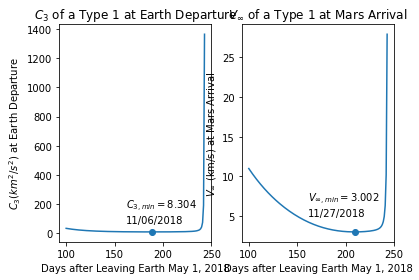

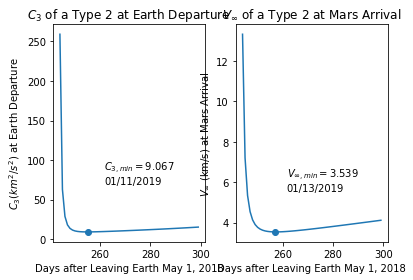

In [15]:
#departure
E_date = pd.Timestamp(year=2018, month=5, day=1).to_julian_date()

#Earth's ephemeris
E_r, E_v = imd.Ephem('Earth',E_date)

#arrival date
M_start_date = E_date + 100

#do Type I followed by Type II
days = 200

#30 day window
C3 = []
v_inf_M = []
dnus = []
M_dates = []
for k in range(days):
    
    #get the transfer
    M_date = M_start_date+k
    M_dates.append(M_date)
    tof = M_date - E_date
    
    #find ephemeris of Mars at arrival
    M_r, M_v = imd.Ephem('Mars',M_date)
    
    #run through Lambert Solver
    v0_vec, vf_vec = imd.ls(E_r, M_r,tof)

    #find TA diff and thus motion direction
    nu0 = np.arctan2(E_r[1][0],E_r[0][0])
    nuf = np.arctan2(M_r[1][0],M_r[0][0])
    dnu = (nuf-nu0) % (2*np.pi)
    
    #get the v_inf at each planet
    v_inf_E_vec = E_v-v0_vec
    v_inf_E = np.linalg.norm(v_inf_E_vec)
    C3.append(v_inf_E**2)
    v_inf_M_vec = M_v-vf_vec
    v_inf_M.append(np.linalg.norm(v_inf_M_vec))
    
    #collect what Type it is
    dnus.append(dnu)

#combine everything important into one matrix
plotters = np.row_stack((C3, v_inf_M, dnus, M_dates))

#split into Type I and Type II
type1_mask = np.array([dnu<np.pi for dnu in dnus], dtype=bool)
type1 = plotters[:,type1_mask]
type2 = plotters[:,~type1_mask]

#plotting
def plot_C3_vinf(type, E_date,n):
    
    #computing minimums
    C3 = type[0,:]
    v_inf = type[1,:]
    mins = [min(C3), min(v_inf)]
    min_dates = [type[3,np.argmin(C3)], type[3,np.argmin(v_inf)]]

    #plot
    plt.figure()
    #C3
    plt.subplot(1,2,1)
    plt.plot(type[3,:]-E_date,type[0,:])
    plt.scatter(min_dates[0]-E_date,mins[0],marker='o')
    mindate1 = pd.to_datetime(min_dates[0], unit='D', origin='julian').strftime("%m/%d/%Y")
    plt.text(np.mean(type[3,:])-E_date-10, mins[0]+60, r'$C_{3,min}=$'+f'{mins[0]:.3f}\n{mindate1}')
    plt.xlabel('Days after Leaving Earth May 1, 2018')
    plt.ylabel (r'$C_3 (km^2/s^2)$ at Earth Departure')
    plt.title(f'${{C_3}}$ of a Type {n} at Earth Departure')
    plt.grid
    #v_inf
    plt.subplot(1,2,2)
    plt.plot(type[3,:]-E_date, type[1,:])
    plt.scatter(min_dates[1]-E_date,mins[1],marker='o')
    mindate2 = pd.to_datetime(min_dates[1], unit='D', origin='julian').strftime("%m/%d/%Y")
    plt.text(np.mean(type[3,:])-E_date-10, mins[1]+2, '$V_{\infty,min}=$'+f'{mins[1]:.3f}\n{mindate2}')
    plt.xlabel('Days after Leaving Earth May 1, 2018')
    plt.ylabel(r'$V_\infty$ (km/s) at Mars Arrival')
    plt.title(f'${{V_\infty}}$ of a Type {n} at Mars Arrival')
    plt.grid


plot_C3_vinf(type1, E_date, 1)
plot_C3_vinf(type2, E_date, 2)
plt.show()

# 2

In [16]:
#find Ceres' distance
T = 1682*86400
mu = MU_SUN_KM
aC = (mu*(T/2/np.pi)**2)**(1/3)
eC = 0.0758
rpC = aC*(1-eC)

#transfer orbit's e
rp = 2.17*AU_KM
ra = 2.57*AU_KM
atr = (rp+ra)/2
e = (ra-rp)/(ra+rp)

#getting the transfer time
nu = np.arccos((atr*(1-e**2)/rpC/e) - 1/e)
E = np.arctan2(np.sin(nu)*np.sqrt(1-e**2),e+np.cos(nu))
dt = (E-e*np.sin(E))*np.sqrt(atr**3/mu)
dtY = dt/86400/365.422

#real transfer time
real_transfer = (pd.Timestamp(year=2015, month=3, day=6).to_julian_date() - pd.Timestamp(year=2012, month=9, day=5).to_julian_date())/365.25
print(real_transfer)

2.4969199178644765
